In [1]:
from pathlib import Path

import nibabel as nib
import numpy as np
from matplotlib import pyplot as plt
from neuromaps.datasets import fetch_fslr
import yaspy
from PIL import Image

from surface_utils import FlatResampler, load_flat, extract_valid_flat

/home/connor/algonauts2025.clean/.venv/lib/python3.11/site-packages/neuromaps/datasets/utils.py:6: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_filename


In [2]:
ROOT = Path("/home/connor/algonauts2025.clean")
print(ROOT)

SUBJECTS = (1, 2, 3, 5)

PIXEL_SIZE = 1.2
RECT = (-330.0, 330.0, -150.0, 160.0)

/home/connor/algonauts2025.clean


In [3]:
import pyvista as pv

pv.start_xvfb()

/home/connor/algonauts2025.clean/.venv/lib/python3.11/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


In [4]:
plt.style.use("clane.mplstyle")
plt.rcParams["figure.dpi"] = 350
PLOTW = 3.5

In [5]:
# 32k_fs_LR surfaces and sulcal depth map
surfaces = fetch_fslr()
surf_lh_path, surf_rh_path = surfaces["inflated"]
sulc_lh_path, sulc_rh_path = surfaces["sulc"]
print(surf_lh_path)
print(sulc_lh_path)

/home/connor/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_inflated.surf.gii
/home/connor/neuromaps-data/atlases/fsLR/tpl-fsLR_den-32k_hemi-L_desc-sulc_midthickness.shape.gii


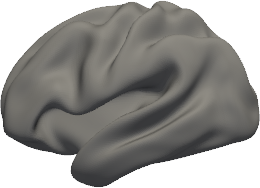

In [6]:
plotter_lh = yaspy.Plotter(surf_lh_path, hemi="lh")
plotter_lh.screenshot()

In [7]:
# Load parcellation label arrays
parc_path = ROOT / "Schaefer2018_1000Parcels_7Networks_order.dlabel.nii"
parc = nib.load(parc_path)
parc_data = parc.get_fdata().squeeze().astype(np.int32)
parc_data_lh, parc_data_rh = np.split(parc_data, 2)
print(parc_data_lh.shape, parc_data_rh.shape)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(32492,) (32492,)


In [8]:
# Load the color lookup table
lut_dict = parc.header.get_axis(0).label[0]

for ii, (k, v) in enumerate(lut_dict.items()):
    print(f"{k}: {v}")
    if ii >= 5:
        break

lut = np.array([v[1] for v in lut_dict.values()])
print("Color LUT shape:", lut.shape)

0: ('???', (1.0, 1.0, 1.0, 0.0))
1: ('7Networks_LH_Vis_1', (0.470588, 0.054902, 0.498039, 1.0))
2: ('7Networks_LH_Vis_2', (0.470588, 0.054902, 0.501961, 1.0))
3: ('7Networks_LH_Vis_3', (0.470588, 0.054902, 0.505882, 1.0))
4: ('7Networks_LH_Vis_4', (0.470588, 0.054902, 0.509804, 1.0))
5: ('7Networks_LH_Vis_5', (0.470588, 0.054902, 0.513726, 1.0))
Color LUT shape: (1001, 4)


In [9]:
# Get the RGBA colors per ROI
parc_rgba = lut[parc_data]
parc_rgba_lh = lut[parc_data_lh]
parc_rgba_rh = lut[parc_data_rh]

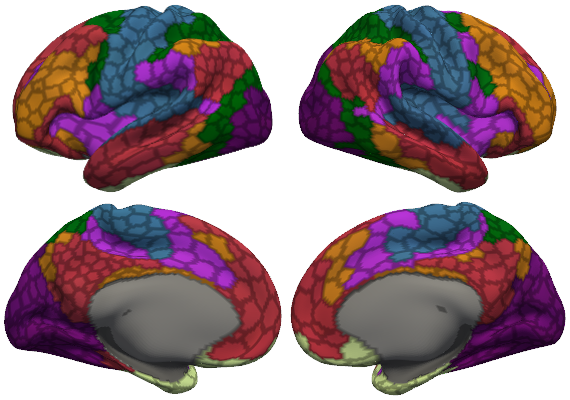

In [11]:
plotter_lh = yaspy.Plotter(surf_lh_path, hemi="lh", sulc=sulc_lh_path)
plotter_rh = yaspy.Plotter(surf_rh_path, hemi="rh", sulc=sulc_rh_path)

plotter_lh.overlay(parc_rgba_lh)
plotter_rh.overlay(parc_rgba_rh)

plotter_lh.border(parc_data_lh, alpha=0.3)
plotter_rh.border(parc_data_rh, alpha=0.3)

parc_surf_panel_img = yaspy.montage(
    [
        [plotter_lh.screenshot("lateral"), plotter_rh.screenshot("lateral")],
        [plotter_lh.screenshot("medial"), plotter_rh.screenshot("medial")],
    ],
    pad=4,
)
parc_surf_panel_img

In [12]:
mask = parc_data > 0
flat = load_flat("32k_fs_LR")
flat, mask = extract_valid_flat(flat, mask)

resampler = FlatResampler(pixel_size=PIXEL_SIZE, rect=RECT)
resampler.fit(flat)

In [14]:
from yaspy._plotter import _border_mask

In [15]:
parc_border_lh = _border_mask(plotter_lh._surf, parc_data_lh)
parc_border_rh = _border_mask(plotter_rh._surf, parc_data_rh)
parc_border = np.concatenate([parc_border_lh, parc_border_rh])

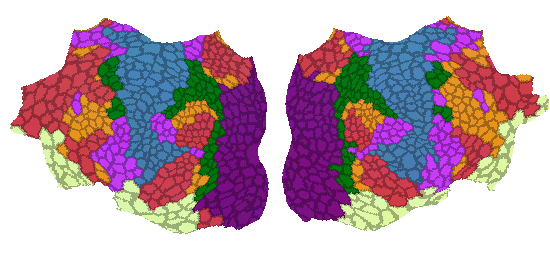

In [33]:
parc_flat = resampler.transform(parc_data[mask], interpolation="nearest")
parc_flat_rgba = lut[parc_flat]

parc_flat_img = Image.fromarray((255 * parc_flat_rgba).astype(np.uint8))

parc_border_flat = resampler.transform(parc_border[mask], interpolation="nearest")
parc_border_rgba = np.where(
    parc_border_flat[:, :, None] > 0,
    np.array([0.0, 0.0, 0.0, 0.3]),
    np.array([1.0, 1.0, 1.0, 0.0]),
)
parc_border_img = Image.fromarray((255 * parc_border_rgba).astype(np.uint8))

parc_flat_img = Image.alpha_composite(parc_flat_img, parc_border_img)
parc_flat_img

In [23]:
default_rois = np.array([k for k, v in lut_dict.items() if "Default" in v[0]])
vis_rois = np.array([k for k, v in lut_dict.items() if "Vis" in v[0]])

In [27]:
default_mask = np.isin(parc_data, default_rois)
vis_mask = np.isin(parc_data, vis_rois)

In [30]:
default_mask_flat = resampler.transform(default_mask[mask], interpolation="nearest")
vis_mask_flat = resampler.transform(vis_mask[mask], interpolation="nearest")

In [34]:
from scipy.ndimage import uniform_filter

In [47]:
def find_mask_boundary(mask):
    boundary = uniform_filter(mask.astype(np.float32))
    boundary = (boundary > 0) & (boundary < 1)
    return boundary

In [53]:
default_boundary_flat = find_mask_boundary(default_mask_flat)
vis_boundary_flat = find_mask_boundary(vis_mask_flat)

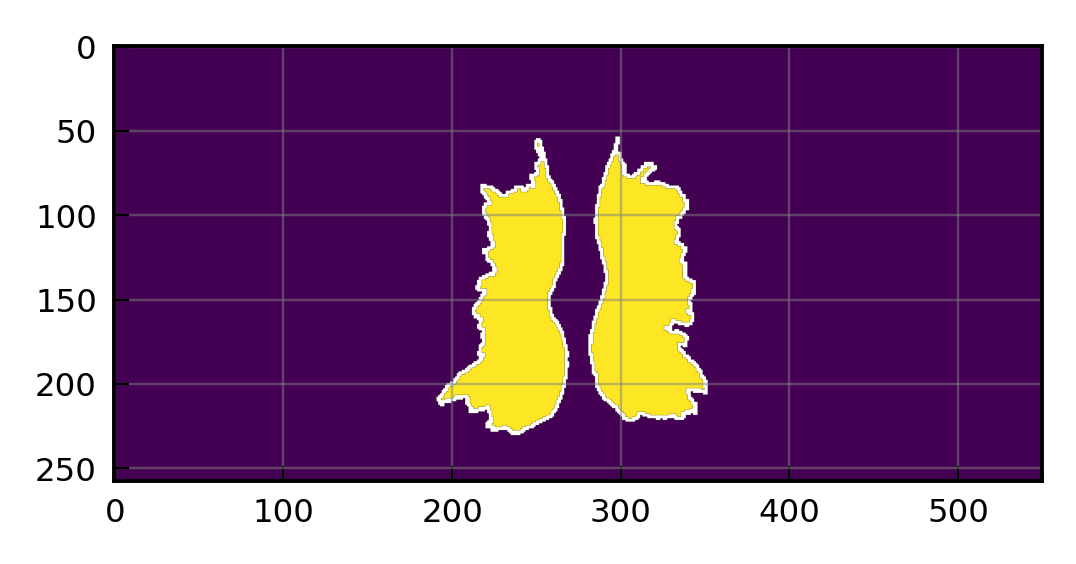

In [54]:
plt.imshow(vis_mask_flat)
plt.imshow(np.where(vis_boundary_flat, 1.0, np.nan), vmin=0.0, vmax=1.0, cmap="gray")

In [57]:
np.savez(
    "schaefer_flat_masks.npz",
    default_boundary_flat=default_boundary_flat,
    vis_boundary_flat=vis_boundary_flat,
)